In [31]:
import numpy as np
import torch_geometric as pyg

from typing import Optional, Tuple
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from biopandas.pdb import PandasPdb
from biopandas.mol2 import PandasMol2
from HGScore.data import process_graph_from_files
import HGScore.model as md
import torch
import seaborn as sns
import pandas as pd



In [32]:
# Based on Graphein


def plotly_protein_structure_graph(
    G: pyg.data.HeteroData,
    pocket_coords,
    ligand_coords,
    plot_title: Optional[str] = None,
    figsize: Tuple[int, int] = (620, 650),
    node_alpha: float = 0.7,
    node_size_min: float = 20.0,
    node_size_multiplier: float = 20.0,
    label_node_ids: bool = True,
    node_colour_map=plt.cm.plasma,
    edge_color_map=plt.cm.plasma,
    colour_nodes_by: str = "degree",
    colour_edges_by: str = "kind",
) -> go.Figure:
    """
    Plots protein structure graph using plotly.

    :param G:  nx.Graph Protein Structure graph to plot
    :type G: nx.Graph
    :param plot_title: Title of plot, defaults to ``None``.
    :type plot_title: str, optional
    :param figsize: Size of figure, defaults to ``(620, 650)``.
    :type figsize: Tuple[int, int]
    :param node_alpha: Controls node transparency, defaults to ``0.7``.
    :type node_alpha: float
    :param node_size_min: Specifies node minimum size. Defaults to ``20.0``.
    :type node_size_min: float
    :param node_size_multiplier: Scales node size by a constant. Node sizes reflect degree. Defaults to ``20.0``.
    :type node_size_multiplier: float
    :param label_node_ids: bool indicating whether or not to plot ``node_id`` labels. Defaults to ``True``.
    :type label_node_ids: bool
    :param node_colour_map: colour map to use for nodes. Defaults to ``plt.cm.plasma``.
    :type node_colour_map: plt.cm
    :param edge_color_map: colour map to use for edges. Defaults to ``plt.cm.plasma``.
    :type edge_color_map: plt.cm
    :param colour_nodes_by: Specifies how to colour nodes. ``"degree"``, ``"seq_position"`` or a node feature.
    :type colour_edges_by: str
    :param colour_edges_by: Specifies how to colour edges. Currently only ``"kind"`` is supported.
    :type colour_nodes_by: str
    :returns: Plotly Graph Objects plot
    :rtype: go.Figure
    """

    # Get Node Attributes
    # pos = nx.get_node_attributes(G, "coords")

    # # Get node colours
    # node_colors = colour_nodes(
    #     G, colour_map=node_colour_map, colour_by=colour_nodes_by
    # )
    # edge_colors = colour_edges(
    #     G, colour_map=edge_color_map, colour_by=colour_edges_by
    # )

    # 3D network plot
    pocket_x_nodes = []
    pocket_y_nodes = []
    pocket_z_nodes = []
    
    ligand_x_nodes = []
    ligand_y_nodes = []
    ligand_z_nodes = []


    for coords in pocket_coords:
        pocket_x_nodes.append(coords[0])
        pocket_y_nodes.append(coords[1])
        pocket_z_nodes.append(coords[2])

    for coords in ligand_coords:
        ligand_x_nodes.append(coords[0])
        ligand_y_nodes.append(coords[1])
        ligand_z_nodes.append(coords[2])

    nodes_pocket = go.Scatter3d(
        x=pocket_x_nodes,
        y=pocket_y_nodes,
        z=pocket_z_nodes,
        mode="markers",
        marker={
            "symbol": "circle",
            "color": 'red',
            "opacity": node_alpha,
            "size": 4
        },
        hoverinfo="text+x+y+z",
    )

    nodes_ligand = go.Scatter3d(
        x=ligand_x_nodes,
        y=ligand_y_nodes,
        z=ligand_z_nodes,
        mode="markers",
        marker={
            "symbol": "circle",
            "color": 'green',
            "opacity": node_alpha,
            "size": 4
        },
        hoverinfo="text+x+y+z",
    )

    ptop_x_edges = []
    ptop_y_edges = []
    ptop_z_edges = []
    for i in range(len(G['protein_atoms', 'linked_to', 'protein_atoms']['edge_index'][0])):
        src = G['protein_atoms', 'linked_to', 'protein_atoms']['edge_index'][0][i]
        dst = G['protein_atoms', 'linked_to', 'protein_atoms']['edge_index'][1][i]
        x_src = pocket_x_nodes[src]
        y_src = pocket_y_nodes[src]
        z_src = pocket_z_nodes[src]
        x_dst = pocket_x_nodes[dst]
        y_dst = pocket_y_nodes[dst]
        z_dst = pocket_z_nodes[dst]
        ptop_x_edges += [x_src, x_dst, None]
        ptop_y_edges += [y_src, y_dst, None]
        ptop_z_edges += [z_src, z_dst, None]

    ltol_x_edges = []
    ltol_y_edges = []
    ltol_z_edges = []
    for i in range(len(G['ligand_atoms', 'linked_to', 'ligand_atoms']['edge_index'][0])):
        src = G['ligand_atoms', 'linked_to', 'ligand_atoms']['edge_index'][0][i]
        dst = G['ligand_atoms', 'linked_to', 'ligand_atoms']['edge_index'][1][i]
        x_src = ligand_x_nodes[src]
        y_src = ligand_y_nodes[src]
        z_src = ligand_z_nodes[src]
        x_dst = ligand_x_nodes[dst]
        y_dst = ligand_y_nodes[dst]
        z_dst = ligand_z_nodes[dst]
        ltol_x_edges += [x_src, x_dst, None]
        ltol_y_edges += [y_src, y_dst, None]
        ltol_z_edges += [z_src, z_dst, None]

    inter_x_edges = []
    inter_y_edges = []
    inter_z_edges = []
    for i in range(len(G['ligand_atoms', 'interact_with', 'protein_atoms']['edge_index'][0])):
        src = G['ligand_atoms', 'interact_with', 'protein_atoms']['edge_index'][0][i]
        dst = G['ligand_atoms', 'interact_with', 'protein_atoms']['edge_index'][1][i]
        x_src = ligand_x_nodes[src]
        y_src = ligand_y_nodes[src]
        z_src = ligand_z_nodes[src]
        x_dst = pocket_x_nodes[dst]
        y_dst = pocket_y_nodes[dst]
        z_dst = pocket_z_nodes[dst]
        inter_x_edges += [x_src, x_dst, None]
        inter_y_edges += [y_src, y_dst, None]
        inter_z_edges += [z_src, z_dst, None]

    # for node_a, node_b in G.edges(data=False):
    #     x_edges.extend([pos[node_a][0], pos[node_b][0], None])
    #     y_edges.extend([pos[node_a][1], pos[node_b][1], None])
    #     z_edges.extend([pos[node_a][2], pos[node_b][2], None])

    axis = dict(
        showbackground=False,
        showline=False,
        zeroline=False,
        showgrid=False,
        showticklabels=False,
        title="",
    )

    edges_ptop = go.Scatter3d(
        x=ptop_x_edges,
        y=ptop_y_edges,
        z=ptop_z_edges,
        mode="lines",
        line={"color": 'red', "width": 2}
    )

    edges_ltol = go.Scatter3d(
        x=ltol_x_edges,
        y=ltol_y_edges,
        z=ltol_z_edges,
        mode="lines",
        line={"color": 'green', "width": 2}
    )

    edges_inter = go.Scatter3d(
        x=inter_x_edges,
        y=inter_y_edges,
        z=inter_z_edges,
        mode="lines",
        line={"color": 'blue', "width": 2}
    )

    return go.Figure(
        data=[nodes_pocket, nodes_ligand, edges_ptop, edges_ltol, edges_inter],#, edges],
        layout=go.Layout(
            title=plot_title,
            width=figsize[0],
            height=figsize[1],
            showlegend=False,
            scene=dict(
                xaxis=dict(axis),
                yaxis=dict(axis),
                zaxis=dict(axis),
            ),
            margin=dict(t=100),
        ),
    )


In [60]:

def get_graph(pdb_id):
    g = process_graph_from_files('../data/raw/{}/{}_pocket.pdb'.format(pdb_id, pdb_id),
                                '../data/raw/{}/{}_ligand.mol2'.format(
                                    pdb_id, pdb_id),
                                pdb_id=pdb_id,
                                atomic_distance_cutoff=4.0
                                )
    ppdb = PandasPdb()
    ppdb.read_pdb('../data/raw/{}/clean_{}_pocket.pdb'.format(pdb_id, pdb_id))

    pocket_coords = ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H'][['x_coord', 'y_coord', 'z_coord']].to_numpy()

    pmol = PandasMol2().read_mol2('../data/raw/{}/{}_ligand.mol2'.format(
                                    pdb_id, pdb_id))
    ligand_coords = pmol.df[pmol.df['atom_type'] != 'H'][['x', 'y', 'z']].to_numpy()                           
    #plotly_protein_structure_graph(g, pocket_coords, ligand_coords)
    
    return g

In [61]:
model_path = "../models/model.ckpt"
model = md.Model.load_from_checkpoint(model_path)

### Change one inter distance

In [69]:
pdb_id = '3uuo'#'5c28'#'4llx'
g = get_graph(pdb_id=pdb_id)

base_value = g['ligand_atoms', 'interact_with', 'protein_atoms']['edge_attr'][0][0].item()

score_list = []
for i in range(-100, 101):
    #i/10 to have between -10 and 10
    new_value = base_value + (i/10)
    g['ligand_atoms', 'interact_with', 'protein_atoms']['edge_attr'][0][0] = torch.tensor(new_value)

    # g['ligand_atoms', 'interact_with', 'protein_atoms']['edge_attr'][0]
    batch = pyg.data.Batch.from_data_list([g])
    score = model.predict(batch)
    score_list += [[i/10, round(score, 2)]]
    #print(round(score, 2), '(Target = {})'.format(2.89))



In [70]:
df = pd.DataFrame(data=score_list, columns=['inter-molecular lenght shift', 'score'])
df

,inter-molecular lenght shift,score
0,-10.0,6.89
1,-9.9,6.88
2,-9.8,6.88
3,-9.7,6.88
4,-9.6,6.88
...,...,...
196,9.6,6.84
197,9.7,6.84
198,9.8,6.84
199,9.9,6.84


[Text(0.5, 1.0, 'Initial Score 6.84')]

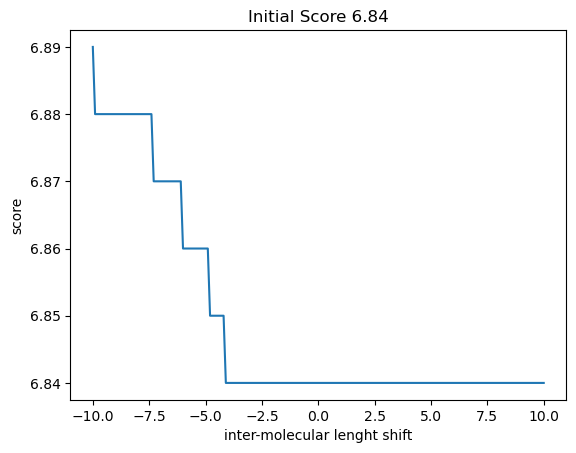

In [71]:
ax = sns.lineplot(data=df, x='inter-molecular lenght shift', y='score')
#ax.axhline(df.loc[df['inter-molecular lenght shift']==0]['score'].item(), color='red')
ax.set(title='Initial Score {}'.format(df.loc[df['inter-molecular lenght shift']==0]['score'].item()))